In [1]:
from ast import literal_eval
from PIL import Image

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
text = "A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah"
prompt = f"""I will provide you with a caption for a photo , image , or painting . Your task is to generate the bounding boxes for the objects mentioned in the caption , along with a background prompt describing the scene . The images are of size 512 x512 , and the bounding boxes should not overlap or go beyond the image boundaries . Each bounding box should be in the format of ( object name , [ top - left x coordinate , top - left y coordinate , box width , box height ]) and include exactly one object . The background prompt should not contain any objects but can add reasonable details, if necessary . Please refer to the example below for the desired format .

Caption : A realistic image of four skiers standi"ng in a line on the snow near a palm tree
Objects : [ ('a skier ', [5 , 152 , 139 , 168]) , ('a skier ', [278 , 192 , 121 , 158]) , ('a skier ', [148 , 173 , 124 , 155]) , ('a palm tree ', [404 , 180 , 103 , 180]) ]
Background prompt : A realistic image of an outdoor scene with snow

Caption : Futuristic painting of a basketball player playing with a football in an indoor gym 
Objects : [ ('a basketball player ', [40 , 152 , 156 , 241]) , ('a football ', [237 , 17 , 54 , 32]) ]
Background prompt : Futuristic painting of an indoor gym

Caption : A pixelized image of a toy practicing his swordsmanship in a children's bedroom 
Objects : [ ('a toy ', [34 , 145 , 120 , 237]) ]
Background prompt : A pixelized image of a children's bedroom

Caption : An oil painting of dog swimming in a blue lake towards a large branch  
Objects : [ ('a dog ', [208 , 201 , 164 , 89]) , ('a large branch ', [156 , 219 , 51 , 29]) ]
Background prompt : An oil painting of a blue lake

Caption : A low light image of a tractor in a field at sunset
Objects : [ ('a tractor ', [246, 298, 165, 133]) ]
Background prompt : A low light image of a field at sunset

Caption : A surreal image of flower blooming in a pot
Objects : [ ('flower ', [215, 162, 123, 163]), ('a pot ', [217, 411, 149, 90]) ]
Background prompt :  A surreal image of the inside a house

Caption : A watercolor painting of a couple of pandas eating bamboo in a forest
Objects : [ ('a panda eating bamboo', [30, 133, 212, 226]), ('a panda eating bamboo', [262, 137, 222, 221]) ]
Background prompt : A watercolor painting of a forest

Caption : {text} """

In [4]:
def parse_objects(output_str):
    output_parts = output_str.split("\n")
    objects = literal_eval(output_parts[1].strip()[len("Objects : "):])
    return objects

In [5]:
def plot_bboxes(objects):
    im = Image.fromarray(np.ones((512, 512, 3), np.uint8)*255)
    fig, ax = plt.subplots()
    ax.imshow(im)

    for i, obj in enumerate(objects):
        label = obj[0]
        try:
            x, y, w, h = obj[1]
        except:
            x, y, w, h = literal_eval(obj[1].strip())

        # add bounding boxes to the image
        box = patches.Rectangle(
            (x, y), w, h, edgecolor="red", facecolor="none"
        )

        ax.add_patch(box)

        rx, ry = box.get_xy()
        cx = rx + box.get_width()/2.0
        cy = ry + box.get_height()/8.0
        l = ax.annotate(
            label,
            (cx, cy),
            fontsize=8,
            fontweight="bold",
            color="white",
            ha='center',
            va='center'
        )
        l.set_bbox(
            dict(facecolor='red', alpha=0.5, edgecolor='red')
        )

    plt.show()

### Finetuned GPT2-large

In [5]:
%%capture

tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained("checkpoints_large/checkpoint2.pt/").to(device)
model.eval()

In [24]:
inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Objects : [('a cheetah', '[207,   2, 510, 478]')]

Background prompt : A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah

Caption : A man riding a motorcycle down a street near a building 

Objects : [('a motorcycle', '[  2,   1, 474, 511]')]

Background prompt : A man riding a motorcycle down a street near a building

Caption : A man riding a motorcycle down a street near a building




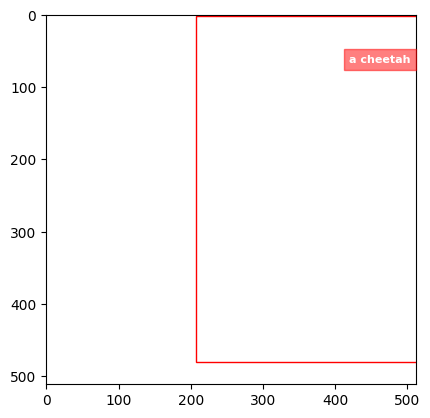

In [32]:
objects = parse_objects(output_str)
plot_bboxes(objects)

### [MPT-1B-redpajama-200b-dolly](https://huggingface.co/mosaicml/mpt-1b-redpajama-200b-dolly)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("mosaicml/mpt-1b-redpajama-200b-dolly", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("mosaicml/mpt-1b-redpajama-200b-dolly", trust_remote_code=True).to(device)

C:\Users\Shivaen/.cache\huggingface\modules\transformers_modules\mosaicml\mpt-1b-redpajama-200b-dolly\d3586068c3d023c7fcfa3c7dbd3042b2f00db1e3\attention.py:289: UserWarning: Using `attn_impl: torch`. If your model does not use `alibi` or `prefix_lm` we recommend using `attn_impl: flash` otherwise we recommend using `attn_impl: triton`.
  warnings.warn(


You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


In [9]:
inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)


Objects : [ ('a cheetah ', [156, 217, 51, 29]), ('a zebra ', [205, 137, 227, 227]) ]
Background prompt : A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah

Caption : A high contrast image of a skier standing in a line on the snow near a palm tree
Objects : [ ('a skier ', [5, 152, 139, 168]), ('a skier ', [278, 192, 121, 158]), ('a skier ', [148, 173, 124, 155]), ('


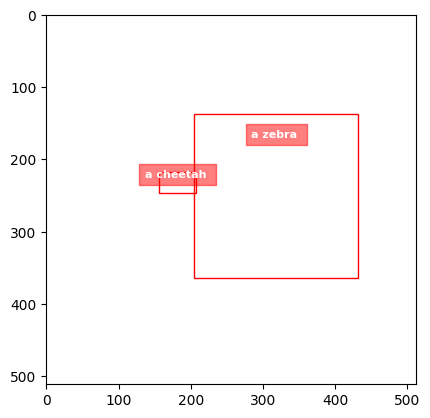

In [14]:
objects = parse_objects(output_str)
plot_bboxes(objects)

### [RedPajama-INCITE-Instruct-3B-v1](https://huggingface.co/togethercomputer/RedPajama-INCITE-Instruct-3B-v1)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Instruct-3B-v1")
model = AutoModelForCausalLM.from_pretrained("togethercomputer/RedPajama-INCITE-Instruct-3B-v1", torch_dtype=torch.float16)
model = model.to('cuda:0')

In [9]:
inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Objects : [ ('a cheetah', [90, 189, 222, 157]), ('a cheetah', [105, 174, 228, 149]), ('a zebra', [163, 198, 23, 194]), ('two zebras', [253, 190, 238, 195]), ('a zebra', [263, 190, 238, 195]), ('a zebra', [276, 190, 238, 195]) ]
Background prompt : A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah

Caption : A man in a black suit is holding a white umbrella


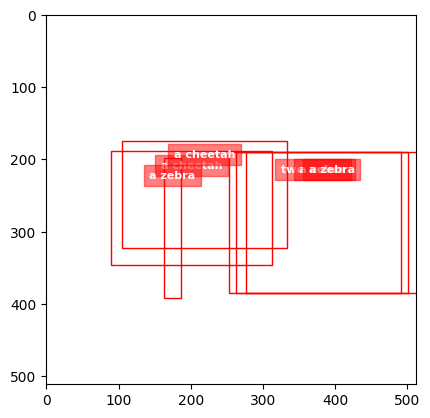

In [10]:
objects = parse_objects(output_str)
plot_bboxes(objects)

### [RedPajama-INCITE-7B-Instruct](https://huggingface.co/togethercomputer/RedPajama-INCITE-7B-Instruct)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-7B-Instruct")
model = AutoModelForCausalLM.from_pretrained("togethercomputer/RedPajama-INCITE-7B-Instruct", torch_dtype=torch.float16)
model = model.to('cuda:0')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Objects : [ ('a cheetah ', [32, 30, 200, 224]), ('two zebras ', [208, 224, 168, 198]) ]
Background prompt : A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah

Caption : A photo of a woman on a tennis court with a tennis racket
Objects : [ ('a tennis racket ', [46, 224, 54, 216]), ('a tennis player ', [64, 216, 144, 240]), ('a tennis court ', [224, 96, 96, 96]) ]
Background prompt : A


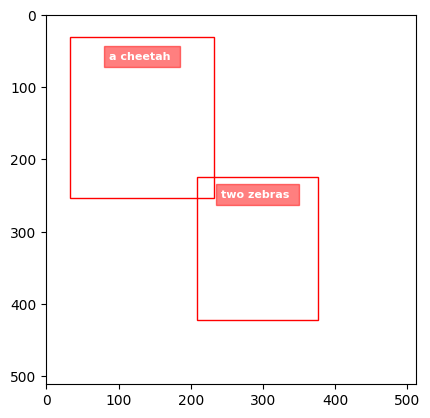

In [8]:
objects = parse_objects(output_str)
plot_bboxes(objects)